# CS933 Image and Video Analysis -- Lab 2

## Department of Computer Science, University of Warwick
## Oct, 2023

## Aims:

The aims of this lab are to

+ learn about image interpolation (upsampling) using nearest-neighbour and bilinear methods
+ binarise an image with a threshold
+ work out how to do connected component labelling
+ estimate centroids and principal axes of image components
+ encode binary images objects as chain codes and run-lengths
+ calculate distance transforms and skeletons 


## Interpolation

The simplest form of interpolation is linear interpolation.

Given values of some scalar function $ f[i] $ at discrete sample points $ i $, if we want to calculate 
    a linear estimate of values at some point $ x $ given $ i \leq x < i+1 $, we can use the formula:
        
$
    a = floor(x)\\
    b = a + 1\\
    dx = x - a\\
    f[x] = f[a] + dx . (f[b]-f[a])
$

In Python, we can write this as:
~~~~
    def interp(f, x):
    
        a = int(np.floor(x))
        b = a + 1
        dx = x - a
        return f[a] + dx * (f[b]-f[a])
~~~~

In [1]:
# import statements

from typing import Final

import matplotlib.pyplot as plt  # this is for plotting (showing) images
import numpy as np  # this imports the numerical and array library
from PIL import Image  # this contains the image class and methods from PIL library


class UtilityAgent:
    __data_dir: Final[str]

    def __init__(self, *, data_dir: str):
        self.__data_dir = data_dir

    def get_img_located_at(
            self,
            location_of_image: str,
            /,
            *,
            channel_mode: str | None = None,
    ) -> np.ndarray:
        """
        Get the image named `name_of_image` from the data directory.
        """
        img = Image.open(f"{self.__data_dir}/{location_of_image}")

        if channel_mode is not None:
            img = img.convert(channel_mode)

        return np.asarray(img)


agent = UtilityAgent(data_dir="../data")

In [2]:
def linear_interpolate_of(x_: np.number, /, *, func: np.ndarray) -> np.float64:
    """
    Linear interpolation of a function func at x_
    Args:
        x_: x value to interpolate at
        func: function to interpolate
    Returns:
        interpolated value
    """
    length_of_func = len(func)

    i_ = int(np.floor(x_))
    if i_ < 0:
        raise ValueError(f"x_: '{x_}' is out of range of func, i_ is smaller than 0")

    i_plus_1 = i_ + 1
    if i_plus_1 >= length_of_func:
        raise ValueError(f"x_: '{x_}' is out of range of func, i_plus_1 is out of range")

    dx = x_ - i_

    # Warning: func[i_plus_1] may be out of range.
    return func[i_] + dx * (func[i_plus_1] - func[i_])

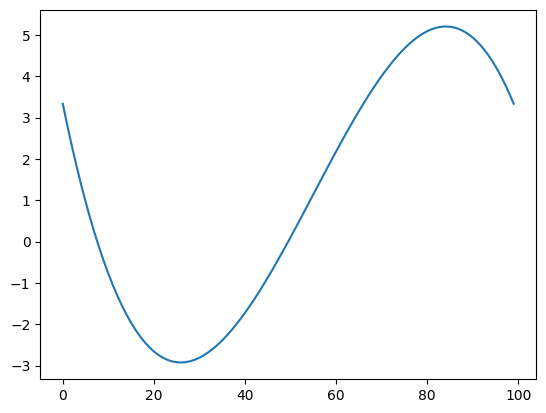

In [3]:
# make an interesting function of 100 values

x = np.linspace(-10, 10, num=100)  # x values
y = x + (x ** 2 / 30) - (x ** 3 / 100)

plt.plot(range(100), y)
plt.show()

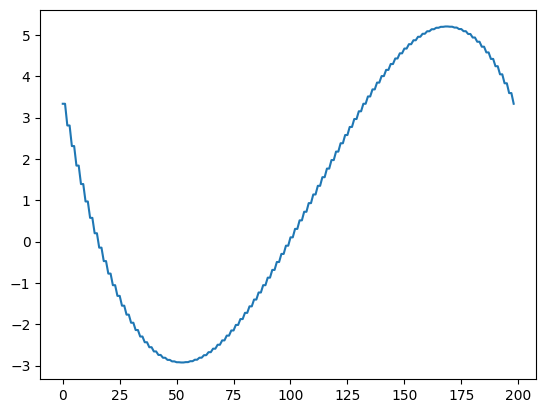

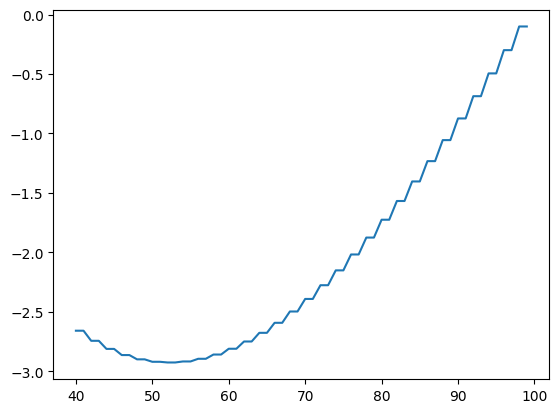

In [4]:
# up_sample y = f(x) by a factor of 2 with nearest-neighbour interpolation
# FIXED: The original code was wrong, which used `2 * (len(y) - 1)`.
# The reason we use `2 * len(y) - 1` is because:
# the original array has len(y) points, when we up-sample by a factor of 2, we want to
# insert one new point between each original point. 
# And There are len(y) - 1 gaps between the original points. 
# So, the total number of points in the up-sampled array should be `len(y)` original points
# plus `len(y) - 1` new points, which equals `2 * len(y) - 1`.
y2_nn = np.zeros(2 * len(y) - 1)

for i in range(len(y2_nn)):
    y2_nn[i] = y[i // 2]

plt.plot(range(len(y2_nn)), y2_nn)
plt.show()

# zoom into range 40:100
plt.plot(range(40, 100), y2_nn[40:100])
plt.show()

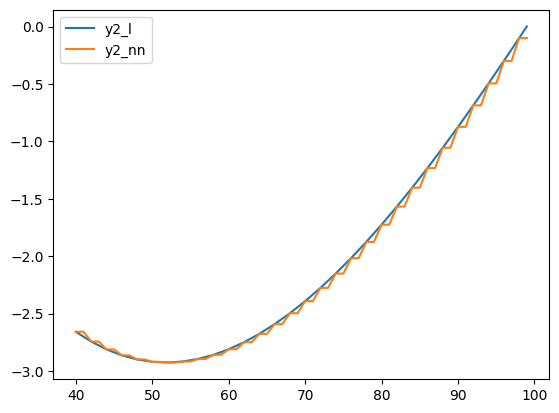

In [5]:
# FIXED: see last section description.
y2_l = np.zeros(2 * len(y) - 1)

for i in range(len(y2_l) - 1):
    # find value between int(x) and int(x)+1 at x
    y2_l[i] = linear_interpolate_of(i / 2.0, func=y)  # linear interpolation

# compare y2_l with y2_nn
plt.plot(range(40, 100), y2_l[40:100], label="y2_l")
plt.plot(range(40, 100), y2_nn[40:100], label="y2_nn")
plt.legend(loc='best')
plt.show()

## Nearest-Neighbour and Bi-Linear Interpolation of Images

With images, to upsample them, we can use nearest neighbour (NN) or bilinear interpolation. 

To upsample using NN, we just need to index to the pixel at the integer position by dividing by the upscaling
    factor, e.g. if the factor is 2, `upsampled[i, j] = original[i//2,j//2]`.
    
Bilinear interpolation take the for 'corner' pixel position values and does linear interpolation
    along the rows (or columns), and then linear along the output of the row (or column) interpolations.
    
$
    a = floor(y)\\   
    b = a + 1
    f[x, y] = linear(linear(f[a], x), linear(f[b], x), y)
$

We can write this in Python like this:
~~~~   
    def bilinear(f, x, y): # f is a 2D array   
        a = int(np.floor(y))  
        
        fa = interp(f[a,:], x)
        fb = interp(f[a+1,:], x)
        
        dy = y - a
        return fa + dy * (fb - fa)
~~~~    

## Exercise 1

1. Using the definitions of `bilinear` and `linear` define a function `upsample`. 
   
   Hint: To do this you will have to iterate over the pixel positions of the output image (upsampled) and find the floating point coordinate (x, y) in the input image and use the bilinear function to calculate the interpolated value.
~~~~
    def upsample(im, factor=2): 
    
        upsampled = np.zeros( factor*(im.shape - np.array([1, 1])) )
        
        for i in range(factor*(im.shape[0] - 1)):
            for j in range(factor*(im.shape[1] - 1)):
            
                x = i/factor
                y = j/factor
                
                upsampled[i, j] = bilinear(im, x, y)
                
        return upsampled
~~~~
2. Test your funciton on a 64 x 64 block from the `testimage512.gif` FM test pattern by a factor of 2, 3 and 4.

   Note: You will have to call this funcition with the input image as `float` types, i.e.
~~~~
    
    im2 = upsampled(im.astype('float'), factor=2)
~~~~
 
3. Compare the results with nearest-neighbour upsampling of the same block



In [6]:
def calculate_bilinear_interpolate_value_in_image(
        image: np.ndarray,
        /,
        *,
        x_of_interpolate_point: np.number,
        y_of_interpolate_point: np.number,
) -> np.float64:
    """
    Bilinear interpolation of a 2D numpy array (image) at a point (x, y).
    This function takes a non-integer location (x, y) and interpolates the
    pixel value at this point based on the surrounding pixel values.

    Args:
        image: 2D numpy array representing an image
        x_of_interpolate_point: x-coordinate (horizontal axis) to interpolate at
        y_of_interpolate_point: y-coordinate (vertical axis) to interpolate at

    Returns:
        interpolated_value: interpolated pixel value at (x, y)

    Raises:
        ValueError: if x and/or y coordinates are out of bounds of the image array
    """
    # Check if the given image is a 2D numpy array
    if image.ndim != 2:
        raise ValueError(
            f"image must be a 2D numpy array, which has {image.ndim} dimensions."
        )

    # Check if the coordinates are within the bounds of the image dimensions
    if (
            not (0 <= x_of_interpolate_point < image.shape[1]) or
            not (0 <= y_of_interpolate_point < image.shape[0])
    ):
        raise ValueError("x and/or y coordinates are out of bounds.")

    # Floor function identifies the top-left corner pixel of the 2x2 pixel square.
    x1, y1 = int(np.floor(x_of_interpolate_point)), int(np.floor(y_of_interpolate_point))

    # To get the bottom-right corner pixel, we add 1 to both coordinates.
    # We use min to prevent going out of bounds of the image.
    x2, y2 = min(x1 + 1, image.shape[1] - 1), min(y1 + 1, image.shape[0] - 1)

    # Calculate the distances (dx, dy) from the top-left pixel to the interpolation point.
    # These distances are used as weights during the interpolation.
    dx = x_of_interpolate_point - x1
    dy = y_of_interpolate_point - y1

    # Interpolate the pixel value horizontally between the top two pixels.
    # This gives us the interpolated top edge value.
    top_edge_value = (1 - dx) * image[y1, x1] + dx * image[y1, x2]

    # Interpolate the pixel value horizontally between the bottom two pixels.
    # This gives us the interpolated bottom edge value.
    bottom_edge_value = (1 - dx) * image[y2, x1] + dx * image[y2, x2]

    # Finally, interpolate vertically between the top and bottom edge values
    # using the vertical distance dy as the weight.
    interpolated_value = (1 - dy) * top_edge_value + dy * bottom_edge_value

    return interpolated_value

In [7]:
def up_sample_2d_image(image: np.ndarray, /, *, factor: int = 2) -> np.ndarray:
    if image.ndim != 2:
        raise ValueError(
            f"image must be a 2D numpy array, which has {image.ndim} dimensions."
        )

    # The 2D version of `2 * length - 1`, where 2 is an example of up-sampling factor.
    scaled = np.zeros(factor * np.array(image.shape) - np.array([1, 1]))

    for y_ in range(scaled.shape[0] - 1):
        for x_ in range(scaled.shape[1] - 1):
            scaled[y_, x_] = calculate_bilinear_interpolate_value_in_image(
                image,
                x_of_interpolate_point=x_ / factor,
                y_of_interpolate_point=y_ / factor,
            )

    return scaled

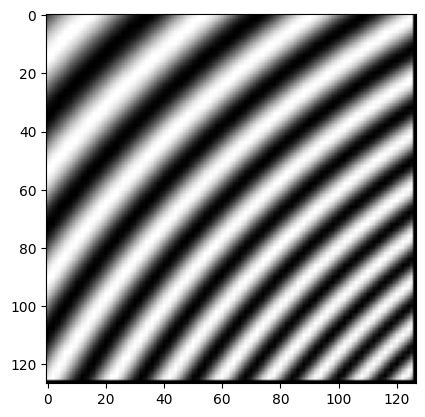

In [8]:
im = agent.get_img_located_at("testimage512.gif")

part_of_im = im[100:164, 100:164]

up_sampled = up_sample_2d_image(part_of_im.astype(np.float64), factor=2)

plt.imshow(up_sampled, cmap="grey")
plt.show()

# Image Binarization and Operations on Binary Images

The next set of experiements and exercises will be done on the `chromosomes.png` image.

We will start by binarising the image,ascii which means mapping the image pixel values to either 1 or 0 (or `True` and `False`). Normally, we want the pixels labelled 1 to be that of objects of interest, and those labelled 0 to be background. 
 
### How to threshold values in an array

Given a Numpy array, `a`, we can threshold it like this:
~~~~
    idx = (a > threshold)  # indices of values greater than threshold value

    a[idx] = 1 # set values at indices to 1
    a[~idx] = 0 # set values below threshold to 0
~~~~

Look at and run the code below to try to understand this concept of selecting index-sets
from arrays. It is a really useful and efficient way to do perform image masking and other 
manipulations (as we will see!)

In [9]:
# Try the following...

# random array of numbers
a = np.random.randint(100, size=(5, 5))
print(a)

# array of booleans where number is > 50
idx = a > 50
print(idx)

# threshold array
b = np.zeros(a.shape, dtype=np.uint8)

# do the thresholding
b[idx] = 1
b[~idx] = 0  # the ~ symbols is the NOT boolean operator

print(b)

[[31 73 66 35 14]
 [ 2 87 45 65 13]
 [85 66 66 45 11]
 [48 77 99  2 72]
 [50 90 80 27 96]]
[[False  True  True False False]
 [False  True False  True False]
 [ True  True  True False False]
 [False  True  True False  True]
 [False  True  True False  True]]
[[0 1 1 0 0]
 [0 1 0 1 0]
 [1 1 1 0 0]
 [0 1 1 0 1]
 [0 1 1 0 1]]


### Binarization of `chromosomes.png` image

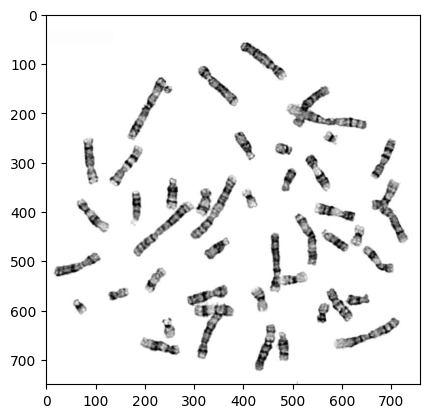

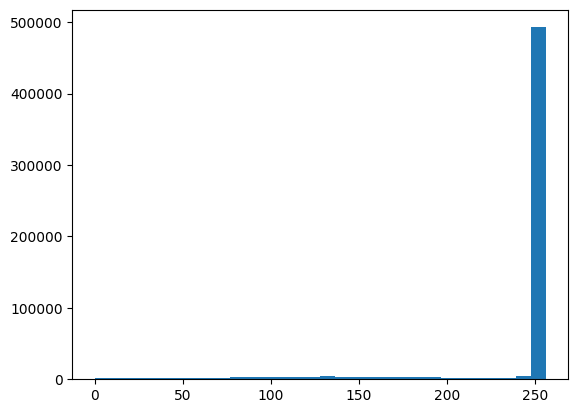

In [10]:
# read the image as a grayscale (1 channel)
chromo = agent.get_img_located_at("chromosomes.png", channel_mode="L")

plt.imshow(chromo, cmap="gray")
plt.show()

# we can use the numpy histogram function to find out the range of values in the image
plt.hist(chromo.ravel(), bins=30, range=(0, 256))  # ravel() is like flatten()
plt.show()

## Exercise 2

1. Use the array thresholding method described above to threshold the `chromo` image to 
roughly separate out the chromosomes from the background.

2. What proportion of pixels are chromosome and what are background in this image?

   Hint: You can count non-zero values in arrays using `numpy.count_nonzero()` or `np.sum()`. To count the number times
   a particular `value` is present in an array, you can use `numpy.count_nonzero(a==value)`, e.g.
~~~~
    # count number of 1s in an array a
    
    number_of_ones = np.count_nonzero(a==1)
~~~~
        
3. What does the histogram tell us about a good choice of threshold to binarise the image?

proportion of chromosome: 13.80580474934037
proportion of background: 86.19419525065963


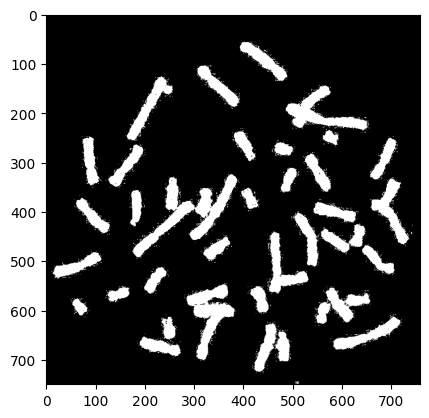

In [11]:
separated = np.where(chromo < 250, 1, 0)
plt.imshow(separated, cmap="grey")

total_chromo_pixels = np.size(chromo)
chromo_percent = np.count_nonzero(separated) / total_chromo_pixels * 100
chromo_bg_percent = 100 - chromo_percent

print(f"proportion of chromosome: {chromo_percent}")
print(f"proportion of background: {chromo_bg_percent}")

# Connected components, Centroids and Principal Axes

We can use the `skiimage.measure` method to do connected component labelling, e.g.
    
~~~~
    comps = measure.label(threshed, background=0)
~~~~

Look at the following code and its output.

unique labels in labeled_chromosome_set are  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67]


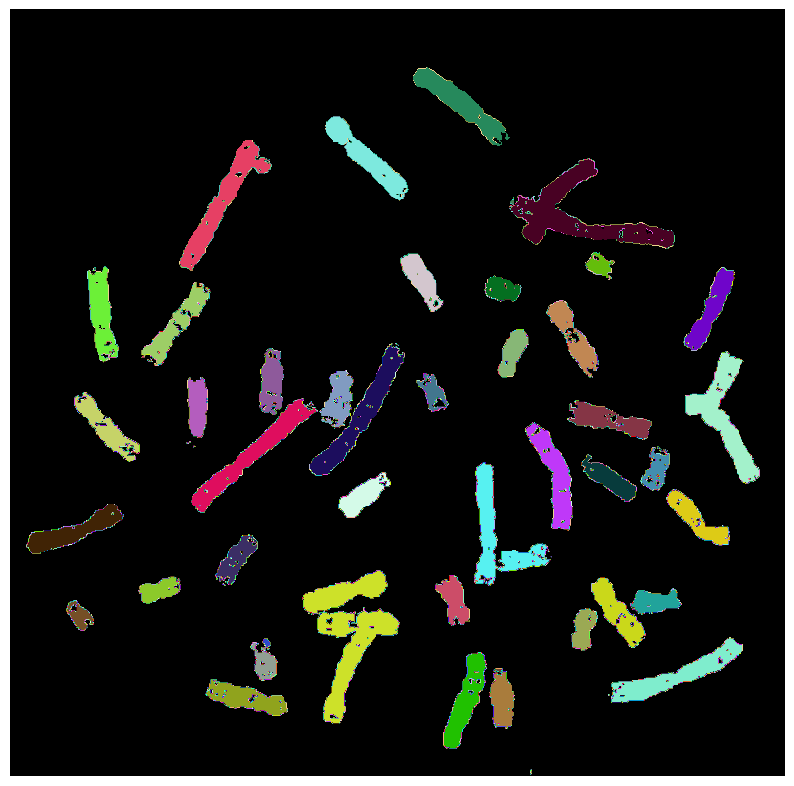

In [12]:
# Connected components, Centroids and Principal Axes
import matplotlib as mpl
from skimage import measure

# threshold at 200
threshed_chromosomes = np.zeros(chromo.shape, np.uint8)
threshed_chromosomes[chromo < 200] = 1

# The output `components` is a ndarray of the same shape as the input image.
# In this array, each pixel is labelled with a unique integer value.
# Pixels with the same integer value belong to the same connected component.
# The background is labelled 0.
labeled_chromosome_set = measure.label(threshed_chromosomes, background=0)
print(
    "unique labels in labeled_chromosome_set are ",
    labels_of_chromosomes := np.unique(labeled_chromosome_set)
)

# make a colour map of random colors
rand_colors = np.random.rand(256, 3)
rand_colors[0, :] = 0.0  # black at zero index
rand_cmap = mpl.colors.ListedColormap(rand_colors)

# print(rand_colors)
fig = plt.figure(figsize=(10, 10))
plt.imshow(labeled_chromosome_set, cmap=rand_cmap)
plt.axis("off")
plt.show()

# Statistics of binarised images

We will now go on to

1. Extract out each of the components by finding its bounding box

2. Find the centroid 

3. Find its principal axis

To do all of these this, it is useful use the `numpy.mesgrid` methods which generates an array of coordinate
positions (acording to an input range of values). 

We can select a subset of these coordinates at the non-zero pixel positions of a binary image and then
find out the minimum and maximum values of these selected coordintes. 

Look at the `bounding_box` method below and try to work out how it is able to find the 
minimum and maximum extents of a given connected component in the original image.

We will see that the same approach will allow us to find the centroids and principal axes of the 
component.

In [13]:
# find the coordinate bounding box of a given label in a components image
def find_bounding_box_from(
        image_: np.ndarray,
        /,
        *,
        label: int
) -> tuple[int, int, int, int]:
    if image_.ndim != 2:
        raise ValueError(
            f"image must be a 2D numpy array, which has {image_.ndim} dimensions."
        )

    # If image.shape is (750, 758), then
    # The created xx looks like this:
    # [[0, 1, 2, ..., 757],
    #  [0, 1, 2, ..., 757],
    #  [0, 1, 2, ..., 757],
    #  ...,
    #  [0, 1, 2, ..., 757],
    #  [0, 1, 2, ..., 757],
    #  [0, 1, 2, ..., 757]]
    #
    # And the created yy looks like this:
    # [[0, 0, 0, ..., 0],
    #  [1, 1, 1, ..., 1],
    #  [2, 2, 2, ..., 2],
    #  ...,
    #  [747, 747, 747, ..., 747],
    #  [748, 748, 748, ..., 748],
    #  [749, 749, 749, ..., 749]]
    xx, yy = np.meshgrid(
        np.arange(0, image_.shape[1]),
        np.arange(0, image_.shape[0])
    )

    # The reason why we do this, is because we want to find the coordinates of the pixels
    # that have the same label as the given label.
    # For example, if the given label is 1, 
    # then we want to find the coordinates of the pixels that have the label 1.
    # And we can do this by comparing the image_ with the given label.
    # 
    # The results in where_x and where_y are 
    # the coordinates of the pixels that have the given label.
    # So we can realize the coordinates of each picked pixel.
    where_x = xx[image_ == label]
    where_y = yy[image_ == label]

    # find min and max extents of coordinates
    return np.min(where_x), np.min(where_y), np.max(where_x), np.max(where_y)

The label 0 has bounding box: (0, 0, 757, 749), and size: 505935


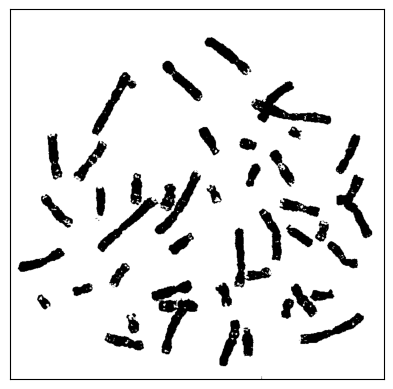

The label 1 has bounding box: (394, 57, 488, 133), and size: 1995


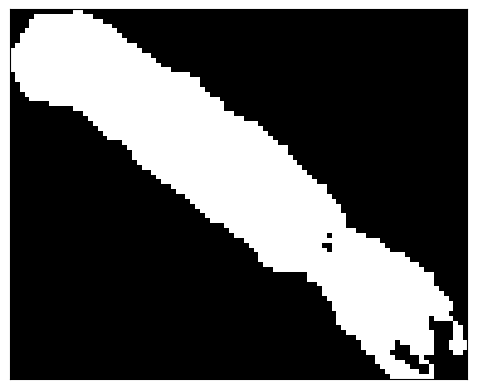

The label 2 has bounding box: (308, 105, 389, 186), and size: 1868


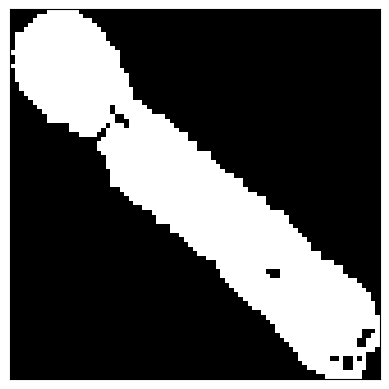

The label 3 has bounding box: (166, 128, 255, 255), and size: 2582


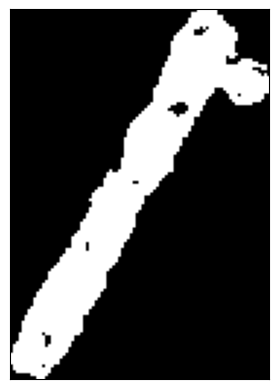

The label 4 has bounding box: (488, 146, 649, 233), and size: 4259


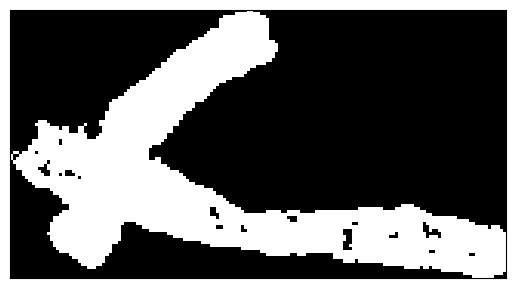

The label 5 has bounding box: (492, 184, 492, 184), and size: 0
The label 6 has bounding box: (489, 186, 492, 190), and size: 9
The label 7 has bounding box: (563, 238, 590, 262), and size: 378


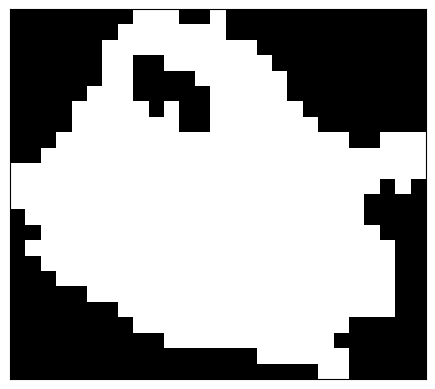

The label 8 has bounding box: (382, 239, 423, 295), and size: 1045


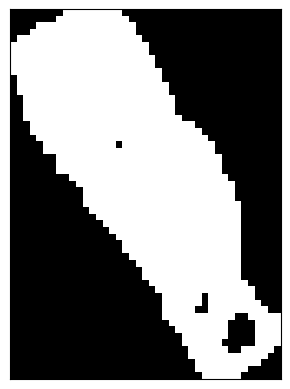

The label 9 has bounding box: (76, 252, 105, 345), and size: 1538


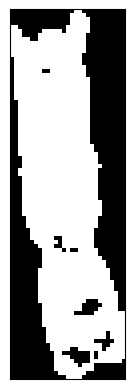

The label 10 has bounding box: (81, 253, 83, 255), and size: 2
The label 11 has bounding box: (659, 253, 708, 333), and size: 1405


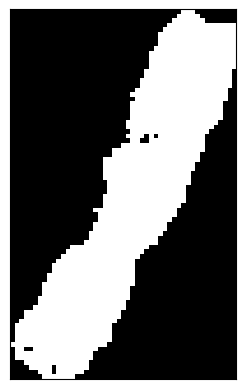

The label 12 has bounding box: (464, 261, 499, 285), and size: 613


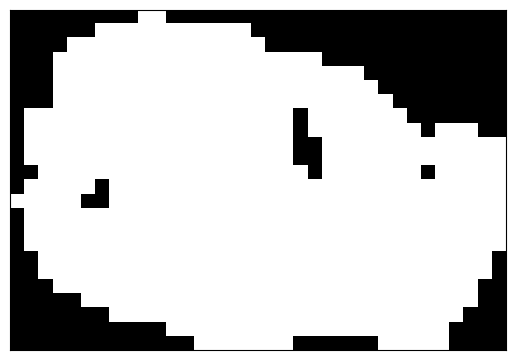

The label 13 has bounding box: (585, 261, 587, 264), and size: 3
The label 14 has bounding box: (129, 267, 195, 348), and size: 1464


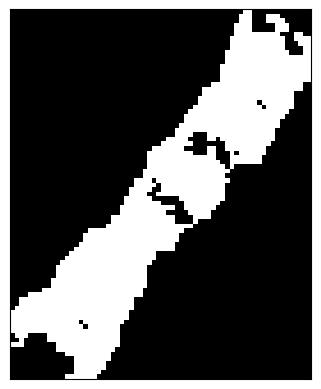

The label 15 has bounding box: (525, 285, 575, 359), and size: 1277


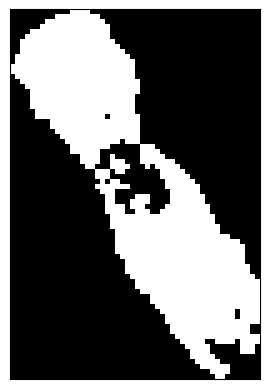

The label 16 has bounding box: (477, 313, 506, 359), and size: 768


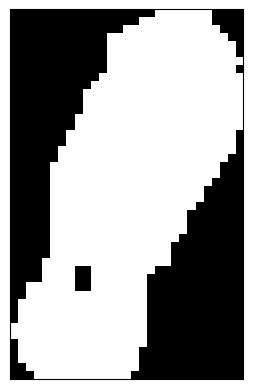

The label 17 has bounding box: (293, 327, 385, 455), and size: 2572


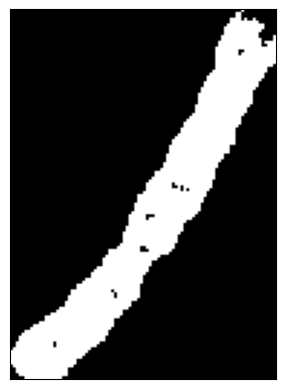

The label 18 has bounding box: (377, 327, 377, 327), and size: 0
The label 19 has bounding box: (379, 328, 379, 328), and size: 0
The label 20 has bounding box: (244, 332, 267, 396), and size: 1084


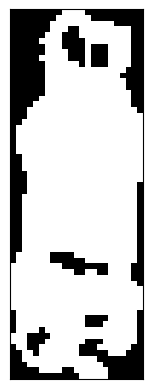

The label 21 has bounding box: (661, 335, 732, 463), and size: 2815


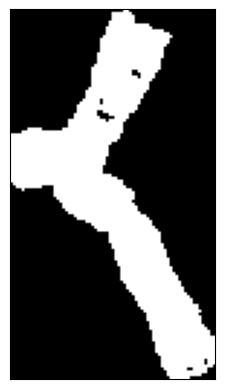

The label 22 has bounding box: (134, 342, 138, 344), and size: 4
The label 23 has bounding box: (303, 353, 335, 409), and size: 1062


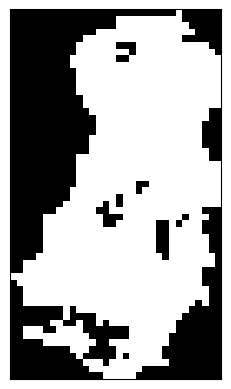

The label 24 has bounding box: (398, 356, 428, 393), and size: 509


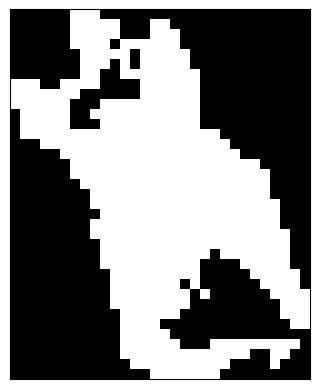

The label 25 has bounding box: (569, 359, 569, 359), and size: 0
The label 26 has bounding box: (174, 360, 192, 418), and size: 878


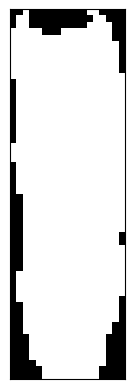

The label 27 has bounding box: (63, 375, 126, 442), and size: 1318


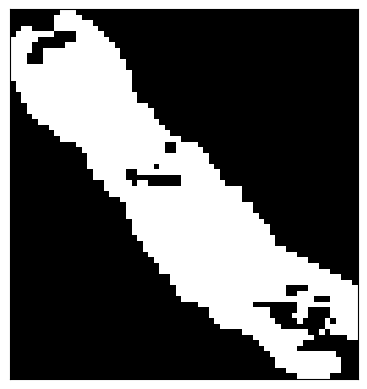

The label 28 has bounding box: (177, 381, 300, 491), and size: 2513


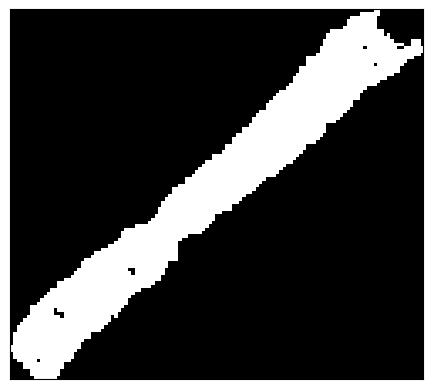

The label 29 has bounding box: (545, 383, 626, 420), and size: 1377


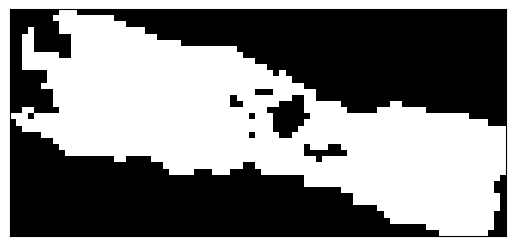

The label 30 has bounding box: (291, 384, 296, 388), and size: 10
The label 31 has bounding box: (305, 399, 306, 399), and size: 0
The label 32 has bounding box: (504, 404, 549, 509), and size: 1846


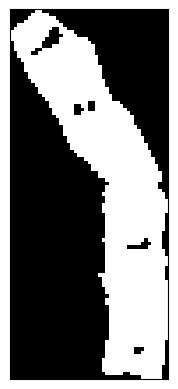

The label 33 has bounding box: (173, 423, 176, 424), and size: 1
The label 34 has bounding box: (179, 427, 180, 428), and size: 1
The label 35 has bounding box: (633, 428, 642, 433), and size: 14
The label 36 has bounding box: (617, 429, 644, 470), and size: 603


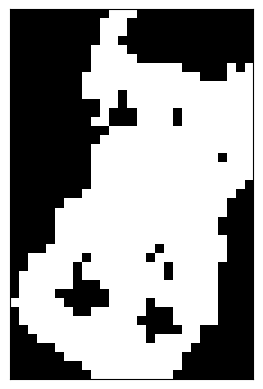

The label 37 has bounding box: (559, 436, 612, 481), and size: 980


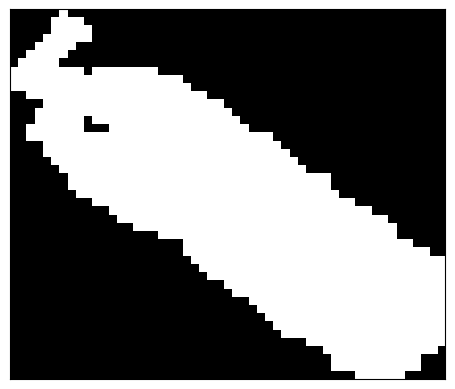

The label 38 has bounding box: (454, 443, 528, 563), and size: 2676


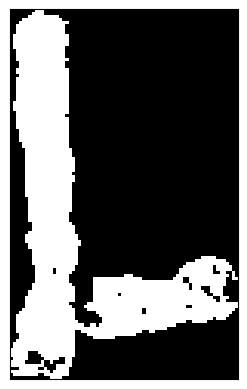

The label 39 has bounding box: (321, 453, 371, 496), and size: 996


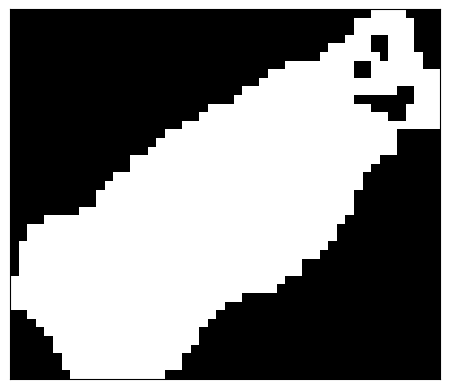

The label 40 has bounding box: (642, 470, 703, 524), and size: 1176


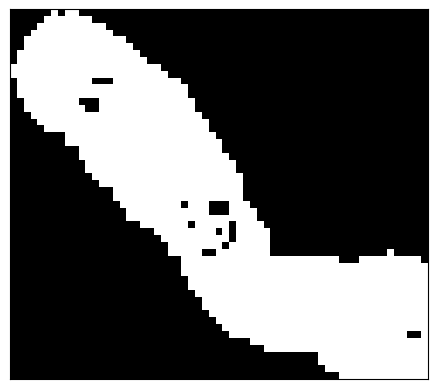

The label 41 has bounding box: (16, 484, 110, 531), and size: 1661


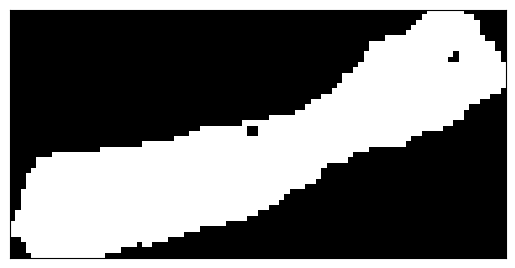

The label 42 has bounding box: (201, 514, 241, 562), and size: 840


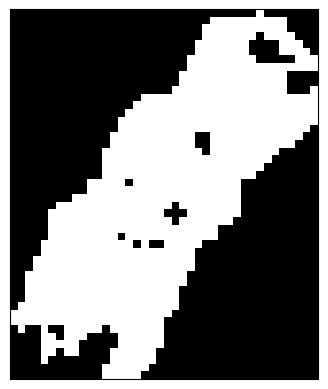

The label 43 has bounding box: (529, 535, 529, 535), and size: 0
The label 44 has bounding box: (286, 549, 380, 698), and size: 4804


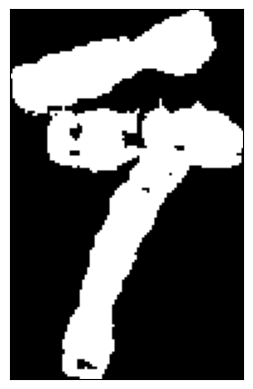

The label 45 has bounding box: (416, 554, 448, 602), and size: 873


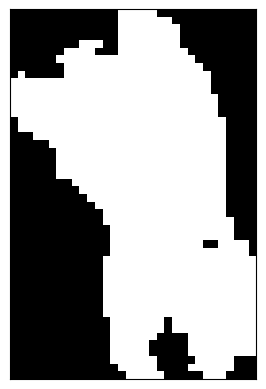

The label 46 has bounding box: (126, 555, 166, 580), and size: 633


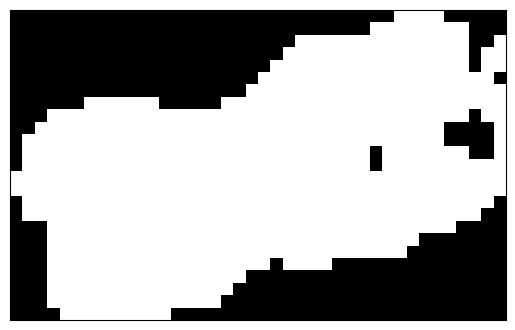

The label 47 has bounding box: (569, 556, 621, 623), and size: 1401


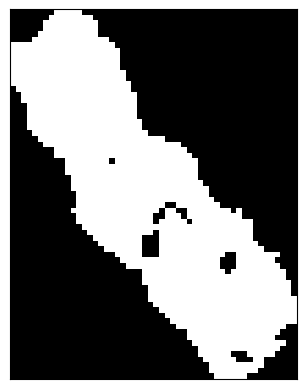

The label 48 has bounding box: (202, 557, 202, 557), and size: 0
The label 49 has bounding box: (211, 560, 211, 560), and size: 0
The label 50 has bounding box: (208, 562, 208, 562), and size: 0
The label 51 has bounding box: (210, 563, 210, 563), and size: 0
The label 52 has bounding box: (607, 567, 656, 591), and size: 779


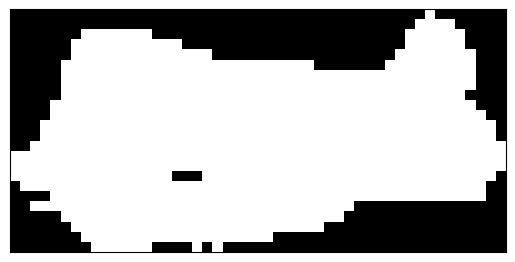

The label 53 has bounding box: (55, 578, 81, 607), and size: 399


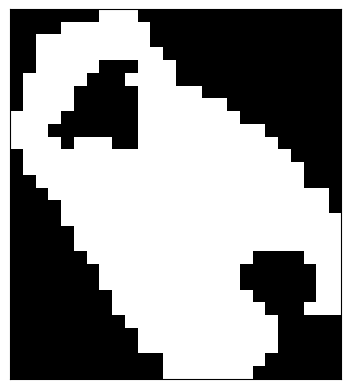

The label 54 has bounding box: (549, 586, 574, 626), and size: 690


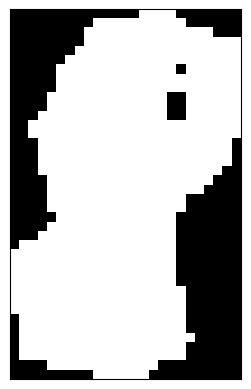

The label 55 has bounding box: (334, 600, 337, 600), and size: 0
The label 56 has bounding box: (620, 615, 620, 615), and size: 0
The label 57 has bounding box: (588, 615, 715, 677), and size: 2254


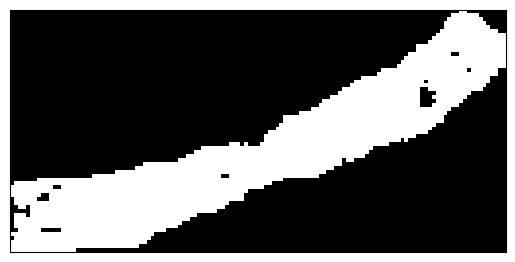

The label 58 has bounding box: (247, 616, 254, 623), and size: 37
The label 59 has bounding box: (235, 619, 261, 656), and size: 551


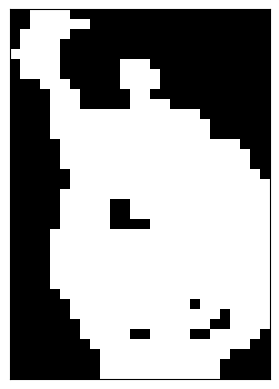

The label 60 has bounding box: (252, 625, 253, 625), and size: 0
The label 61 has bounding box: (424, 629, 465, 722), and size: 1695


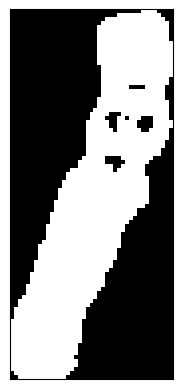

The label 62 has bounding box: (473, 645, 481, 648), and size: 21
The label 63 has bounding box: (469, 648, 492, 703), and size: 967


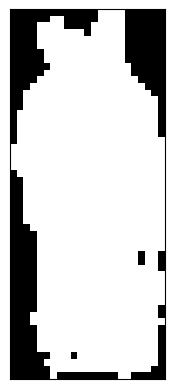

The label 64 has bounding box: (191, 656, 270, 690), and size: 1404


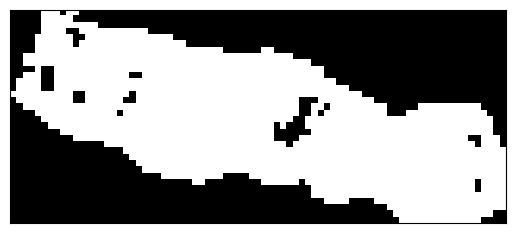

The label 65 has bounding box: (585, 670, 585, 670), and size: 0
The label 66 has bounding box: (509, 744, 509, 745), and size: 0
The label 67 has bounding box: (509, 747, 509, 748), and size: 0


In [14]:
# the following code finds the bounding boxes of each component and
# then creates a sub-image (one_comp), and stores this in a list

# the code also discards any small components (less than min_size in size)

min_size = 100

bounding_boxes: list[[int, int, int, int]] = []
single_chromosomes: list[np.ndarray] = []

for the_label in labels_of_chromosomes:
    left, top, right, bottom = find_bounding_box_from(
        labeled_chromosome_set,
        label=the_label
    )

    # make a binary image for each component
    target_component = np.zeros_like(labeled_chromosome_set)
    target_component[labeled_chromosome_set == the_label] = 1
    target_component = target_component[top:bottom, left:right]

    # measure its size
    n = np.count_nonzero(target_component)

    print(
        f"The label {the_label} has bounding box: {left, top, right, bottom}, "
        f"and size: {n}"
    )

    # plot as image if it's big enough (greater than min_size)
    if n > min_size:
        bounding_boxes.append((left, top, right, bottom))
        single_chromosomes.append(target_component)

        plt.imshow(target_component, cmap="gray")
        plt.xticks([])
        plt.yticks([])

        plt.show()

In [15]:
def find_centroid_from(image_: np.ndarray, /) -> np.ndarray:
    if image_.ndim != 2:
        raise ValueError(
            f"image must be a 2D numpy array, which has {image_.ndim} dimensions."
        )

    xx, yy = np.meshgrid(
        np.arange(0, image_.shape[1]),
        np.arange(0, image_.shape[0])
    )

    # mask by where im is non-zero
    non_zero_x_points = xx[image_ != 0]
    non_zero_y_points = yy[image_ != 0]

    # return the mean of the coordinates of the component
    return np.array([np.mean(non_zero_x_points), np.mean(non_zero_y_points)])

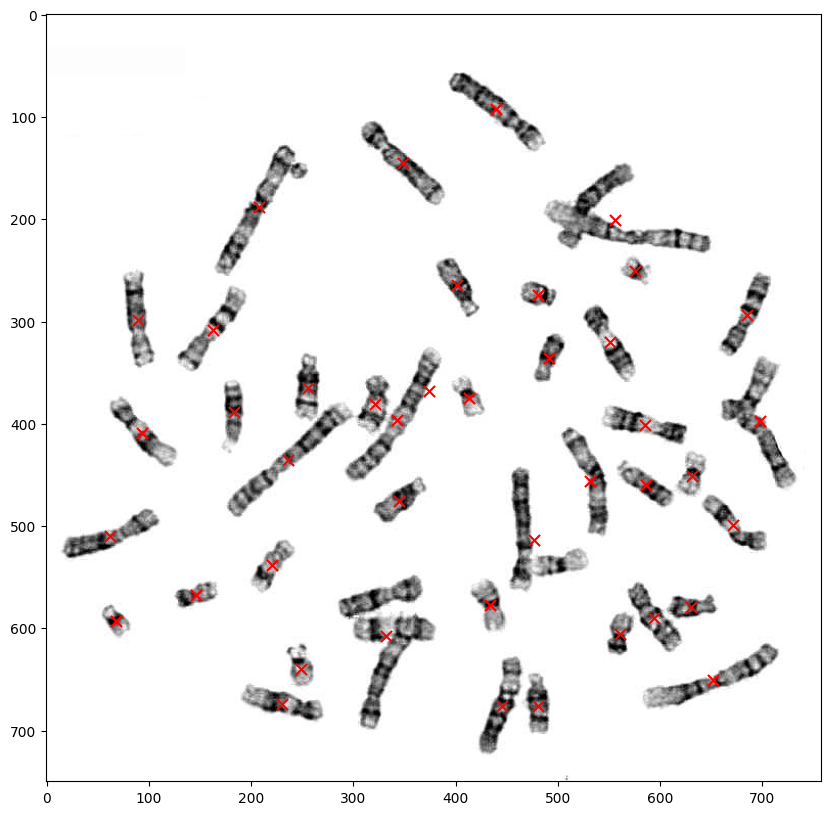

In [16]:
# test out the centroid function
fig = plt.figure(figsize=(10, 10))
plt.imshow(chromo, cmap="gray")

centroids: list[[]] = []

# overlay the centroid positions of each connected component
for i, chromosome in enumerate(single_chromosomes):
    left, top, _, __ = bounding_boxes[i]
    centroid_x, centroid_y = find_centroid_from(chromosome)
    centroids.append([centroid_x, centroid_y])

    # plt.scatter is useful to plot points as a given marker on an image
    plt.scatter((left + centroid_x), (top + centroid_y), marker="x", s=64, c=[(1, 0, 0)])

plt.show()

## Principal Axes

To calculate the principal axes of a binary component, we need to find the principal eigen vector
of the covariance of the coordinates (with respect to the centroid). Mathematically, this 
is calculated by:
    
$
    C = \frac{1}{N}\sum_k  \mathbf{x}_k \mathbf{x}_k^T
$
where $ N $ is the number of pixels and $ \mathbf{x} $ is the coordinate of the pixel. $ C $ is the 
covariance matrix which then needs to be decomponsed into eigen values and eigen vectors
$
    C \mathbf{v}_j = \lambda_j \mathbf{v}_j
$
Since $ C $ is a 2 x 2 matrix, there are two eigen values and two eigen vectors. 

The principal axis $ \mathbf{p} $ is the eigen vector assocated with the largest eigen value.

To implement this, I have written a function `principal_axes`. Try to understand what it does.




In [17]:
def find_principal_axes_from(image_: np.ndarray) -> np.ndarray:
    """
    Finds the principal axes of a labeled region in a 2D array (image).
    This function assumes the region of interest is labeled by non-zero values.

    Args:
        image_: 2D numpy array representing an image.

    Returns:
        p_axes: The eigenvector corresponding to the largest eigenvalue, which
        represents the direction of the principal axis.
    """
    # Check that the provided image array is two-dimensional.
    if image_.ndim != 2:
        raise ValueError("Input must be a 2D numpy array.")

    # Determine the 'center of mass' for the non-zero pixels in the image.
    centroid_x_, centroid_y_ = find_centroid_from(image_)

    # Generate two arrays representing the x and y coordinates for each pixel.
    xx, yy = np.meshgrid(np.arange(image_.shape[1]), np.arange(image_.shape[0]))

    # Filter out the coordinates of pixels that are zero, and shift the remaining
    # pixel coordinates by the centroid values to center them at the origin (0,0).
    x_shifted = xx[image_ != 0] - centroid_x_
    y_shifted = yy[image_ != 0] - centroid_y_

    # Combine the centered x and y coordinates into a single 2-row array.
    # This forms a set of 2D vectors pointing from the centroid to each non-zero pixel.
    centered_coordinates = np.vstack((x_shifted, y_shifted))

    # Compute the 'inertia tensor' for the distribution of non-zero pixels,
    # which is similar to the covariance matrix but not normalized by the number of pixels.
    inertia_tensor = np.matmul(centered_coordinates, centered_coordinates.T)

    # Solve for the eigenvectors and eigenvalues of the inertia tensor.
    # The eigenvectors represent the directions of the axes of the pixel distribution,
    # and the eigenvalues represent the 'spread' or 'weight' along these axes.
    eigenvalues, eigenvectors = np.linalg.eig(inertia_tensor)

    # Select the eigenvector associated with the largest eigenvalue.
    # This vector represents the principal axis of the distribution,
    # which is the direction along which the pixels are most spread out.
    principal_axis = eigenvectors[0, :] if eigenvalues[0] > eigenvalues[1] else eigenvectors[1, :]

    return principal_axis

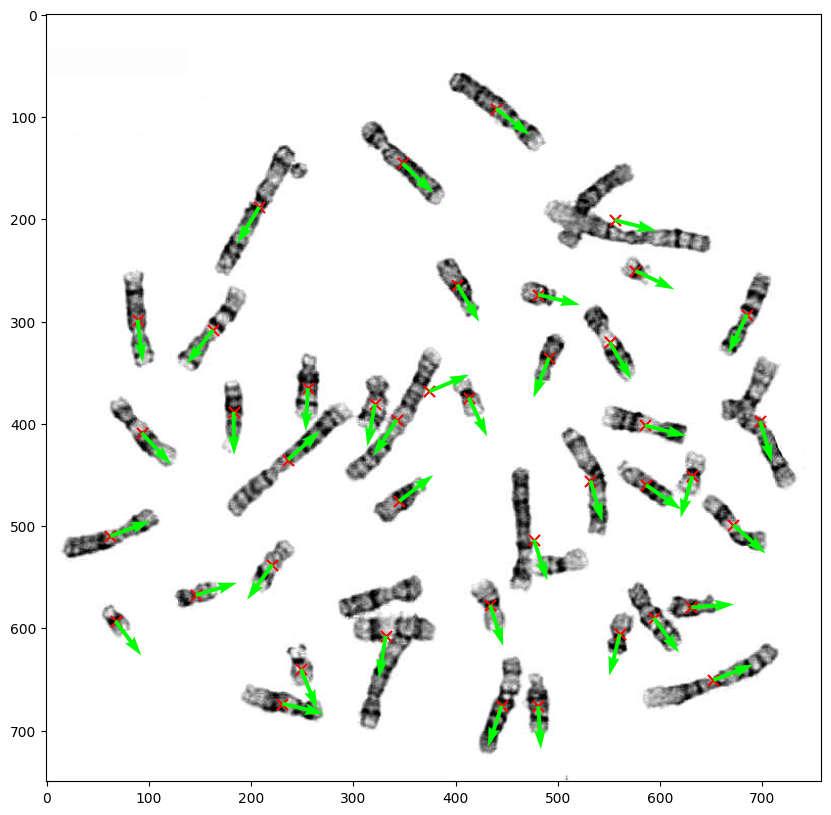

In [18]:
# test out the principal axes code
fig = plt.figure(figsize=(10, 10))
plt.imshow(chromo, cmap="gray")

# overlay centroid and principal axis (as arrow) on top of image
for i, chromosome in enumerate(single_chromosomes):
    left, top, right, bottom = bounding_boxes[i]

    centroid_x, centroid_y = centroids[i]
    principal_axes = find_principal_axes_from(chromosome)

    plt.scatter((left + centroid_x), (top + centroid_y), marker="x", s=64, c=[(1, 0, 0)])
    plt.quiver(
        left + centroid_x,
        top + centroid_y,
        principal_axes[0],
        principal_axes[1],
        width=0.005,
        color=(0, 1, 0)
    )

plt.show()

## Exercise 3

Select an image of your own which can be easily binarised into an foreground and a background.

1. Perform the operation of binarisation (perhaps by looking at the histogram of the image first)

2. Find the connected components in the image and extract them out as separate images.

3. Plot the centroids and principal axes on your binarised image

4. Make a table of showing the component, its size, its centroid position and the angle of its principal axis


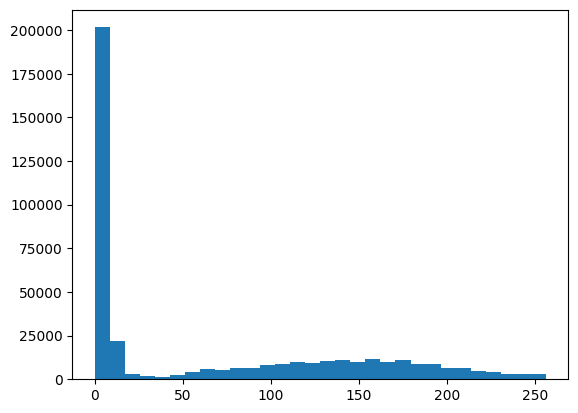

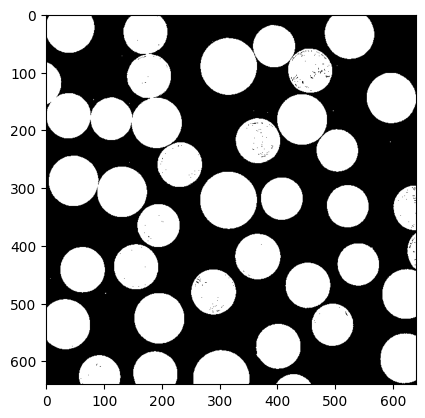

In [40]:
coins = agent.get_img_located_at("coins.jpg", channel_mode="L")

threshed_coins = np.where(coins < 40, 0, 1)

plt.hist(coins.ravel(), bins=30, range=(0, 256))
plt.show()

plt.imshow(threshed_coins, cmap="gray")
plt.show()

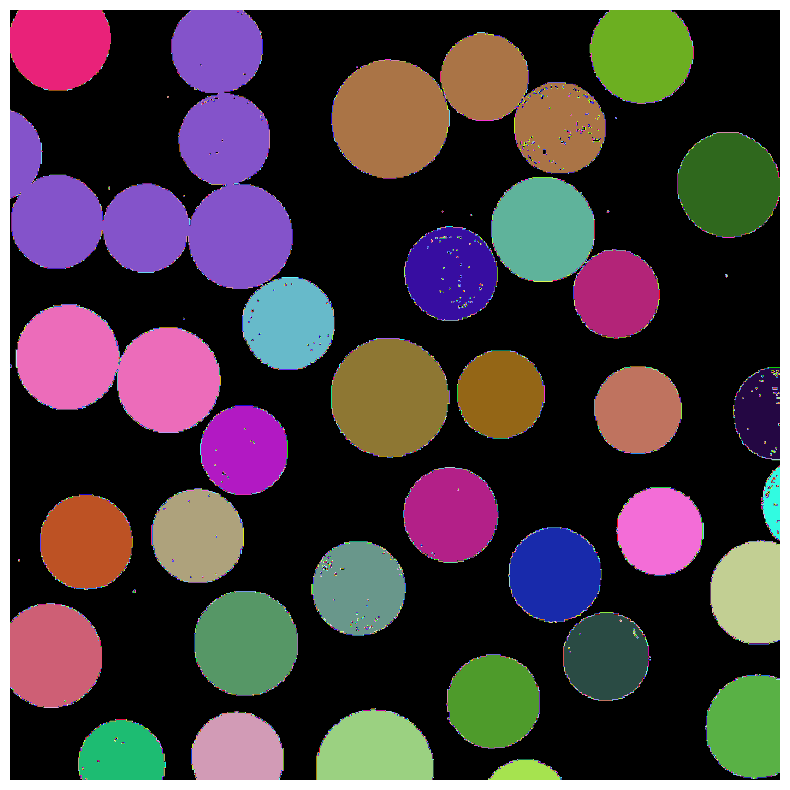

In [41]:
labeled_coin_set = measure.label(threshed_coins, background=0)

# make a colour map of random colors
rand_colors = np.random.rand(256, 3)
rand_colors[0, :] = 0.0  # black at zero index
rand_cmap = mpl.colors.ListedColormap(rand_colors)

fig = plt.figure(figsize=(10, 10))
plt.imshow(labeled_coin_set, cmap=rand_cmap)
plt.axis("off")
plt.show()

The label 0 has bounding box: (0, 0, 639, 639), and size: 228402


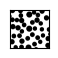

The label 1 has bounding box: (0, 0, 83, 66), and size: 4739


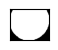

The label 2 has bounding box: (0, 0, 234, 231), and size: 25078


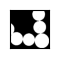

The label 3 has bounding box: (482, 0, 567, 77), and size: 5478


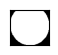

The label 4 has bounding box: (267, 19, 494, 139), and size: 16099


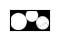

The label 5 has bounding box: (288, 47, 288, 47), and size: 0


/var/folders/b4/g7zzg4q10p3fjfry3y9vz5_w0000gn/T/ipykernel_41207/284145352.py:28: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(target_component, cmap="gray")
/var/folders/b4/g7zzg4q10p3fjfry3y9vz5_w0000gn/T/ipykernel_41207/284145352.py:28: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(target_component, cmap="gray")


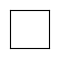

The label 6 has bounding box: (131, 72, 131, 72), and size: 0


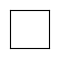

The label 7 has bounding box: (503, 89, 503, 89), and size: 0


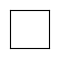

The label 8 has bounding box: (555, 102, 639, 188), and size: 5809


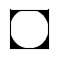

The label 9 has bounding box: (400, 139, 485, 225), and size: 5912


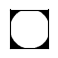

The label 10 has bounding box: (82, 147, 82, 148), and size: 0


The label 11 has bounding box: (144, 154, 144, 154), and size: 0


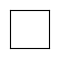

The label 12 has bounding box: (359, 167, 359, 167), and size: 0


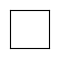

The label 13 has bounding box: (496, 167, 497, 167), and size: 0


The label 14 has bounding box: (383, 170, 383, 170), and size: 0


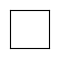

The label 15 has bounding box: (328, 180, 404, 257), and size: 4580


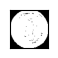

The label 16 has bounding box: (468, 199, 539, 272), and size: 4096


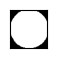

The label 17 has bounding box: (595, 220, 595, 221), and size: 0


The label 18 has bounding box: (193, 222, 269, 298), and size: 4605


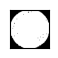

The label 19 has bounding box: (5, 245, 174, 350), and size: 11772


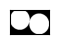

The label 20 has bounding box: (144, 256, 144, 256), and size: 0


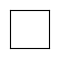

The label 21 has bounding box: (267, 273, 364, 371), and size: 7614


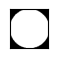

The label 22 has bounding box: (372, 283, 443, 355), and size: 4164


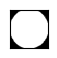

The label 23 has bounding box: (0, 295, 0, 296), and size: 0


The label 24 has bounding box: (486, 296, 557, 368), and size: 4132


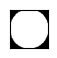

The label 25 has bounding box: (601, 297, 639, 373), and size: 2272


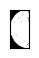

The label 26 has bounding box: (158, 329, 230, 402), and size: 4230


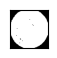

The label 27 has bounding box: (625, 379, 639, 440), and size: 564


The label 28 has bounding box: (327, 380, 405, 458), and size: 4819


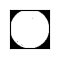

The label 29 has bounding box: (504, 397, 575, 469), and size: 4117


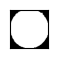

The label 30 has bounding box: (118, 398, 193, 475), and size: 4654


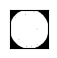

The label 31 has bounding box: (25, 403, 101, 481), and size: 4754


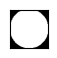

The label 32 has bounding box: (414, 430, 491, 508), and size: 4757


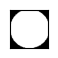

The label 33 has bounding box: (582, 441, 639, 526), and size: 4125


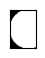

The label 34 has bounding box: (251, 442, 328, 519), and size: 4678


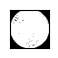

The label 35 has bounding box: (7, 457, 7, 457), and size: 0


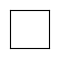

The label 36 has bounding box: (102, 482, 103, 483), and size: 0


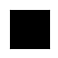

The label 37 has bounding box: (153, 483, 238, 569), and size: 5921


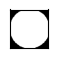

The label 38 has bounding box: (0, 493, 75, 579), and size: 5455


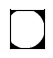

The label 39 has bounding box: (460, 501, 531, 573), and size: 4107


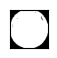

The label 40 has bounding box: (363, 536, 439, 613), and size: 4692


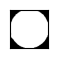

The label 41 has bounding box: (578, 552, 639, 638), and size: 4397


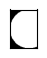

The label 42 has bounding box: (255, 581, 351, 639), and size: 4555


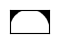

The label 43 has bounding box: (151, 583, 226, 639), and size: 3552


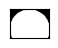

The label 44 has bounding box: (57, 590, 128, 639), and size: 2901


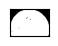

The label 45 has bounding box: (398, 623, 457, 639), and size: 670


In [47]:
labels_of_coins = np.unique(labeled_coin_set)

coin_bounding_boxes: list[[int, int, int, int]] = []
single_coins: list[np.ndarray] = []

for the_label in labels_of_coins:
    left, top, right, bottom = find_bounding_box_from(
        labeled_coin_set,
        label=the_label
    )

    # make a binary image for each component
    target_component = np.zeros_like(labeled_coin_set)
    target_component[labeled_coin_set == the_label] = 1
    target_component = target_component[top:bottom, left:right]

    # measure its size
    n = np.count_nonzero(target_component)

    print(
        f"The label {the_label} has bounding box: {left, top, right, bottom}, "
        f"and size: {n}"
    )

    coin_bounding_boxes.append((left, top, right, bottom))
    single_coins.append(target_component)
    plt.figure(figsize=(0.5, 0.5))
    plt.imshow(target_component, cmap="gray")
    plt.xticks([])
    plt.yticks([])

    plt.show()
        

/Users/xanonymous/Library/Caches/pypoetry/virtualenvs/cs933-lab-hsaNNLEO-py3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/xanonymous/Library/Caches/pypoetry/virtualenvs/cs933-lab-hsaNNLEO-py3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


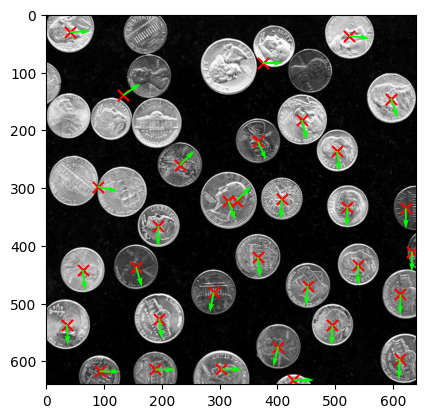

In [49]:
plt.imshow(coins, cmap="gray")

# overlay centroid and principal axis (as arrow) on top of image
for i, coin in enumerate(single_coins):
    left, top, right, bottom = coin_bounding_boxes[i]

    centroid_x, centroid_y = find_centroid_from(coin)
    principal_axes = find_principal_axes_from(coin)

    plt.scatter((left + centroid_x), (top + centroid_y), marker="x", s=64, c=[(1, 0, 0)])
    plt.quiver(
        left + centroid_x,
        top + centroid_y,
        principal_axes[0],
        principal_axes[1],
        width=0.005,
        color=(0, 1, 0)
    )

plt.show()

## Distance transforms and Skeletons

Binarised data can be represented by its skelton and we can also calculate what is called a *distance transform*
where each pixel in the image is given a distance to the closest object boundary (either internal to the object,
or external of the object).

The `scipy.ndimage.morphology` module has methods to calculate distance transforms of binarised images. Like the following.

### Exercise 4

1. What could you use distannce transforms and skeletons for?


In [20]:
# Distance transforms and Skeletons
# Skimage skeletons
import scipy.ndimage as morpho
import skimage.morphology as sci_morpho

dt = morpho.distance_transform_edt(component_images[1])
dt_not = morpho.distance_transform_edt(~(component_images[1].astype("bool")))

plt.imshow(dt)
plt.show()

plt.imshow(dt_not)
plt.show()

skel = sci_morpho.skeletonize(component_images[1])
plt.imshow(skel, cmap="gray")
plt.show()

NameError: name 'component_images' is not defined

## Run-length encoding and Chain Codes

Run-length encoding takes a binarised image and sweeps across the image, pixel-by-pixel, row-by-row counting
the numbers of consecutive 1's and 0's encountered. The output is the number of pixels which were 1 (or 0) in any 
given run or sequence. 

Chain codes are generated by starting at a boundary pixel of a binary image and walking around the edge outputing
one of 8 directions, encoded as 0..8 for the 8 directions you can go from boundary pixel to boundary pixel.


## Exercise 5

1. Write a function to convert a binary image to a run-length encoded output. 
You can output the image dimensions, the initial state (1 or 0) and then a sequence of integers for the run-lengths.

Hint: It will help to flatten the input image using `numpy.ravel()` when finding the runs.

2. Write a funciton to take your run-length encoded image and reconstruct it.

Hint: Store the output of your answer to (1) as a list of integers and pass this as input to your decoder, which should return a binary image. You can make a 1D array of the image and then reshape it using `numpy.reshape()` to be rectangular.

3. Test your function on the chromosomes components generated in this lab. How does the run-length encoding compare in size to the original image (if you assume that each integer can be encoded as 8 bits).

4. Write a function to generate chain codes from a binary image and test it on the chromosomes components images.

